In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### 读入数据

In [2]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

## 基于单层决策树构建弱分类器  
伪代码：  
将最小错误率minError设为+∞  
对数据集中的每一个特征（第一层循环）：  
&ensp;&ensp;&ensp;&ensp;对每个步长（第二层循环）：  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;对每个不等号（第三层循环）：  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;建立一颗单层决策树并利用加权数据集对它进行测试  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;如果错误率低于minError，则将当前单层决策树设为最佳单层决策树  
返回最佳单层决策树

### 通过阈值比较进行分类

In [3]:
def stumpClassify(dataMatrix, dimen, threshVal,threshIneq):
    retArray = np.ones((np.shape(dataMatrix)[0], 1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray

### 找到具有最低错误率的单层决策树

In [4]:
def buildStump(dataArr, classLabels, D):
    dataMatrix = np.mat(dataArr)
    labelMat = np.mat(classLabels).T
    m, n = np.shape(dataMatrix)
    numSteps = 10.0
    bestStump = {}    # 定义空字典，存储给定D时的单层决策树信息
    bestClassEst = np.mat(np.zeros((m, 1)))
    minError = np.inf    # 寻找最小错误率
    for i in range(n):    # 在数据集的所有特征上遍历
        rangeMin = dataMatrix[:, i].min()
        rangeMax = dataMatrix[:, i].max()
        stepSize = (rangeMax - rangeMin)/numSteps    # 需要的步长
        for j in range(-1, int(numSteps)+1):    # 对步长遍历
            for inequal in ['lt', 'gt']:
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = np.mat(np.ones((m, 1)))
                errArr[predictedVals == labelMat] = 0    # 等则对，不等则错
                weightedError = D.T * errArr    # 加权错误率
                #print('split: dim %d, thresh %.2f,thresh ineqal: %s,the weighted error is %.3f' % (i,threshVal,inequal,weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClassEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClassEst

## 完整AdaBoost算法  
伪代码：
对每次迭代：  
&ensp;&ensp;&ensp;&ensp;利用buildStump()函数找到最佳的单层决策树  
&ensp;&ensp;&ensp;&ensp;将最佳单层决策树加入到单层决策树数组  
&ensp;&ensp;&ensp;&ensp;计算alpha  
&ensp;&ensp;&ensp;&ensp;计算新的权重向量$D$  
&ensp;&ensp;&ensp;&ensp;更新累计类别估计值  
&ensp;&ensp;&ensp;&ensp;如果错误率等于0.0，则退出循环

In [5]:
def adaBoostTrainDS(dataArr, classLabels, numIt=40):    # numIt:迭代次数
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m, 1))/m)
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        #print('D:', D.T)
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        #print('classEst:', classEst.T)
        # 计算下一次迭代的D
        expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst)
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum()
        aggClassEst += alpha * classEst
        #print('aggClassEst:', aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m, 1)))
        errorRate = aggErrors.sum() / m
        print('total error:', errorRate, '\n')
        if errorRate == 0.0:
            break
    return weakClassArr, aggClassEst

## AdaBoost分类函数

In [6]:
def adaClassify(datToClass, classifierArr):
    dataMatrix = np.mat(datToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'], classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha'] * classEst
        #print(aggClassEst)
    return np.sign(aggClassEst)

## ROC曲线绘制及AUC计算函数

In [7]:
def plotROC(predStrengths, classLabels):
    cur = (1.0, 1.0)
    ySum = 0.0
    numPosClas = sum(np.array(classLabels)==1.0)
    yStep = 1 / float(numPosClas)
    xStep = 1 / float(len(classLabels) - numPosClas)
    sortedIndicies = predStrengths.argsort()
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        ax.plot([cur[0], cur[0] - delX], [cur[1], cur[1] - delY], c = 'b')
        cur = (cur[0] - delX, cur[1] - delY)
    ax.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for AdaBoost Horse Colic Detection System')
    ax.axis([0, 1, 0, 1])
    plt.show()
    print('the Area Under the Curve is: ',ySum * xStep)

In [8]:
datArr, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray, aggClassEst = adaBoostTrainDS(datArr, labelArr, 50)

total error: 0.2842809364548495 

total error: 0.2842809364548495 

total error: 0.24749163879598662 

total error: 0.24749163879598662 

total error: 0.25418060200668896 

total error: 0.2408026755852843 

total error: 0.2408026755852843 

total error: 0.22073578595317725 

total error: 0.24749163879598662 

total error: 0.23076923076923078 

total error: 0.2408026755852843 

total error: 0.2140468227424749 

total error: 0.22742474916387959 

total error: 0.21739130434782608 

total error: 0.22073578595317725 

total error: 0.21739130434782608 

total error: 0.22408026755852842 

total error: 0.22408026755852842 

total error: 0.23076923076923078 

total error: 0.22408026755852842 

total error: 0.2140468227424749 

total error: 0.20735785953177258 

total error: 0.22408026755852842 

total error: 0.22408026755852842 

total error: 0.2140468227424749 

total error: 0.22073578595317725 

total error: 0.2040133779264214 

total error: 0.20735785953177258 

total error: 0.21070234113712

In [9]:
testArr, testLabelArr = loadDataSet('horseColicTest2.txt')
prediction10 = adaClassify(testArr, classifierArray)

In [10]:
errArr = np.mat(np.ones((67, 1)))
errArr[prediction10 != np.mat(testLabelArr).T].sum()

14.0

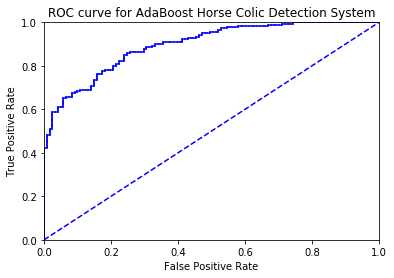

the Area Under the Curve is:  0.8953941870182941


In [11]:
plotROC(aggClassEst.T, labelArr)